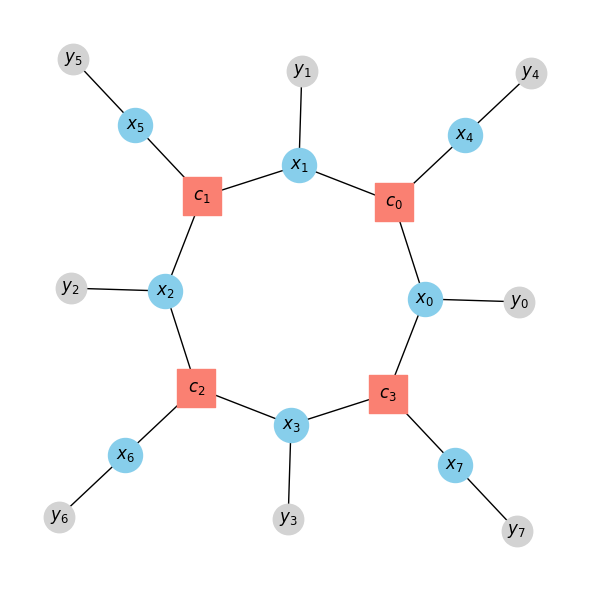

In [1]:
import numpy as np

from decoders import decode_bpqm, decode_single_codeword, decode_single_syndrome, create_init_qc
from cloner import VarNodeCloner
from linearcode import LinearCode

from qiskit import QuantumCircuit

# 1. Define the [8,4] code (Section 6)
G = np.array([
    [1, 0, 0, 0, 1, 0, 0, 1],
    [0, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 0, 1, 1],
])
H = np.array([
    [1, 1, 0, 0, 1, 0, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 1, 0, 0, 1, 0],
    [1, 0, 0, 1, 0, 0, 0, 1],
])

code = LinearCode(G, H)

code.plot_factor_graph(backend="matplotlib")


In [2]:
code.plot_factor_graph(
    backend="pyvis",
    variable_size=100,
    output_size=100,
    output_color="gray",
    font_size=24,
    width="900px",
    height="900px",
    html_file="factor_graph.html",
    latex_subscripts=True,
)


In [3]:
# 3. BPQM decoding
theta = 0.2 * np.pi
cloner = VarNodeCloner(theta)

# 3a. Single‐bit decode (bit index 4)
p_bit = decode_bpqm(
    code,
    theta,
    cloner=cloner,
    height=2,
    mode='bit',
    bit=4,
    only_zero_codeword=True,
    debug=False
)
print("Success probability for bit 4:", p_bit)

# 3b. Full‐codeword decode (bits [0,1,2,3])
p_codeword = decode_bpqm(
    code,
    theta,
    cloner=cloner,
    height=2,
    mode='codeword',
    order=[0, 1, 2, 3],
    only_zero_codeword=True,
    debug=False
)
print("Success probability for the full codeword:", p_codeword)


Success probability for bit 4: 0.8602192421422509
Success probability for the full codeword: 0.6893367460101051


In [4]:
# Decode a specific codeword and obtain the measurement outcome
code = LinearCode(None, H)
message = np.array([0, 0, 1, 1])
codeword = message @ G % 2
corrupted_codeword = codeword.copy()
error_position = 3
corrupted_codeword[error_position] = 1 if corrupted_codeword[error_position] == 0 else 0

qc_init = create_init_qc(
    code=code,
    codeword=corrupted_codeword,
    theta=theta,
    prior=None      # or set a prior like 0.5
)

# 5) Decode with BPQM and print debug counts:
decoded_bits, decoded_qubits, qc_decode = decode_single_codeword(
    qc_init=qc_init,
    code=code,
    cloner=cloner,
    height=2,
    shots=1024,
    debug=True,      # prints reversed & sorted counts + syndrome
    run_simulation=True
)
print("Codeword          : ", codeword)
print("Corruped codeword : ", corrupted_codeword)
print("Decoded bits      : ", decoded_bits)


Counts:
  00110101 → 319 : syndrome [0 0 0 0]
  00100110 → 148 : syndrome [0 0 0 0]
  11000101 → 75 : syndrome [0 0 0 0]
  00000000 → 59 : syndrome [0 0 0 0]
  10101111 → 46 : syndrome [0 0 0 0]
  11100011 → 24 : syndrome [0 0 0 0]
  10001001 → 22 : syndrome [0 0 0 0]
  00100111 → 17 : syndrome [0 0 0 1]
  00100100 → 14 : syndrome [0 0 1 0]
  10101101 → 14 : syndrome [0 0 1 0]
  01111001 → 14 : syndrome [0 0 0 0]
  10111100 → 13 : syndrome [0 0 0 0]
  01001100 → 12 : syndrome [0 0 0 0]
  00110100 → 12 : syndrome [0 0 0 1]
  00000100 → 10 : syndrome [0 1 0 0]
  00010011 → 10 : syndrome [0 0 0 0]
  00000001 → 9 : syndrome [0 0 0 1]
  00100101 → 9 : syndrome [0 0 1 1]
  00110001 → 8 : syndrome [0 1 0 0]
  10100111 → 8 : syndrome [1 0 0 0]
  11110000 → 8 : syndrome [0 0 0 0]
  10100101 → 8 : syndrome [1 0 1 0]
  00111101 → 7 : syndrome [1 0 0 0]
  00100001 → 7 : syndrome [0 1 1 1]
  01101010 → 6 : syndrome [0 0 0 0]
  10110101 → 5 : syndrome [1 0 0 1]
  00110111 → 5 : syndrome [0 0 1 0]
  

In [5]:
syndrome = corrupted_codeword @ H.T %2
print("Syndrome: ", syndrome)

Syndrome:  [0 0 1 1]


In [ ]:
qc_init = create_init_qc(
    code=code,
    codeword=None,
    theta=theta,
    prior=0.5      # or set a prior like 0.5
)

syndrome_qc = QuantumCircuit(len(syndrome))
for i, s in enumerate(syndrome):
    if s == 1:
        syndrome_qc.x(i)

decoded_bits, decoded_qubits, qc_decode = decode_single_syndrome(
    qc_init=qc_init,
    syndrome_qc=syndrome_qc,
    code=code,
    cloner=cloner,
    height=2,
    shots=512,
    debug=True,
    run_simulation=True
)
print("syndrome             : ", syndrome)
print("Corruped codeword    : ", corrupted_codeword)
print("Decoded bits         : ", decoded_bits)
if decoded_bits is not None:
    print("Decoded bits syndrome: ", decoded_bits @ H.T %2)

Counts:
  11110011 → 36 : syndrome [0 0 1 1]
  11000110 → 32 : syndrome [0 0 1 1]
  00100101 → 31 : syndrome [0 0 1 1]
  10011001 → 30 : syndrome [0 0 1 1]
  10111111 → 29 : syndrome [0 0 1 1]
  10001010 → 29 : syndrome [0 0 1 1]
  01011100 → 29 : syndrome [0 0 1 1]
  00000011 → 28 : syndrome [0 0 1 1]
  01101001 → 28 : syndrome [0 0 1 1]
  11010101 → 28 : syndrome [0 0 1 1]
  00010000 → 26 : syndrome [0 0 1 1]
  11100000 → 25 : syndrome [0 0 1 1]
  01001111 → 25 : syndrome [0 0 1 1]
  10101100 → 24 : syndrome [0 0 1 1]
  01111010 → 24 : syndrome [0 0 1 1]
  00110110 → 23 : syndrome [0 0 1 1]
  01000111 → 3 : syndrome [1 0 1 1]
  00000111 → 3 : syndrome [0 1 1 1]
  00001011 → 3 : syndrome [1 0 1 1]
  00000010 → 3 : syndrome [0 0 1 0]
  00100100 → 3 : syndrome [0 0 1 0]
  01111011 → 2 : syndrome [0 0 1 0]
  10001011 → 2 : syndrome [0 0 1 0]
  01011110 → 2 : syndrome [0 0 0 1]
  01111000 → 2 : syndrome [0 0 0 1]
  11000111 → 2 : syndrome [0 0 1 0]
  10011011 → 2 : syndrome [0 0 0 1]
  01

In [7]:
decoded_qubits

[13, 14, 15, 16, 17, 18, 19, 5]

In [8]:
# qc_decode.draw('mpl', fold=-1)